# Titanic Disaster 

## The Challenge 

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

## Goal 

Predict if a passenger survived the sinking of the Titanic or not.

For each in the test set, predict a 0 or 1 value for the variable.



## The Data

Train.csv will contain the details of a subset of the passengers on board (891 to be exact) and importantly, will reveal whether they survived or not, also known as the “ground truth”.

The test.csv dataset contains similar information but does not disclose the “ground truth” for each passenger. It’s your job to predict these outcomes.

Using the patterns you find in the train.csv data, predict whether the other 418 passengers on board (found in test.csv) survived.

This notebook will take you through the steps needed to train a baseline Gradient Boosted Trees Model using TensorFlow Decision Forests.

This notebook shows:

How to do some basic pre-processing. For example, the passenger names will be tokenized, and ticket names will be splitted in parts.
How to train a Gradient Boosted Trees (GBT) with default parameters
How to train a GBT with improved default parameters
How to tune the parameters of a GBTs
How to train and ensemble many GBTs

## Import Dependencies

Print versions to verify successful import.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow_decision_forests as tfdf

print(f"Found numpy {np.__version__}")
print(f"Found pandas {pd.__version__}")
print(f"Found seaborn {sns.__version__}")
print(f"Found tensorflow {tf.__version__}")
print(f"Found TF-DF {tfdf.__version__}")

2024-04-06 11:15:04.777069: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found numpy 1.26.4
Found pandas 2.1.4
Found seaborn 0.12.2
Found tensorflow 2.16.1
Found TF-DF 1.9.0


## Load Dataset

In [3]:
train_df = pd.read_csv("train.csv")
serving_df = pd.read_csv("test.csv")

train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


## Explore the data

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train_df.describe(include=["O"])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


Lets have a look at the survival rates for different catagories via the groupby method. 

Class Survival Rate:

In [7]:
train_df.groupby(['Pclass'], as_index=False)['Survived'].mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


Sex Survival Rate:

In [8]:
train_df.groupby(['Sex'], as_index=False)['Survived'].mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


Number of Siblings/Spouses Survival Rate:

In [9]:
train_df.groupby(['SibSp'], as_index=False)['Survived'].mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


Number of Parents/Children Survial Rate:

In [10]:
train_df.groupby(['Parch'], as_index=False)['Survived'].mean()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


Lets create a category called Family Size. Which will consist of adding SibSp (number of siblings and spouses one has) to Parch (number of parents and children one has) and adding 1 (to count oneself).

In [11]:
train_df['Family_Size'] = train_df['SibSp'] + train_df['Parch'] + 1
serving_df['Family_Size'] = train_df['SibSp'] + train_df['Parch'] + 1

Family size Survival Rate:

In [12]:
train_df.groupby(['Family_Size'], as_index=False)['Survived'].mean()

,Family_Size,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


Lets group the fimly size. 

In [13]:
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4:'Small', 5: 'Medium', 6: 'Medium', 7:'Large', 8:'Large', 11: 'Large'}
train_df['Family_Size_Grouped'] = train_df['Family_Size'].map(family_map)
serving_df['Family_Size_Grouped'] = train_df['Family_Size'].map(family_map)

Family Size (Grouped) Survival Rate:

In [14]:
train_df.groupby(['Family_Size_Grouped'], as_index=False)['Survived'].mean()

,Family_Size_Grouped,Survived
0,Alone,0.303538
1,Large,0.160000
2,Medium,0.162162
3,Small,0.578767


Embarkment Survival Rates:

In [15]:
train_df.groupby(['Embarked'], as_index=False)['Survived'].mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


Build a graph (seaborn) to display the information and see the distributions. Lets do this for Age as an example. The left graph displays those who did not survive, and on the right those who did survive.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


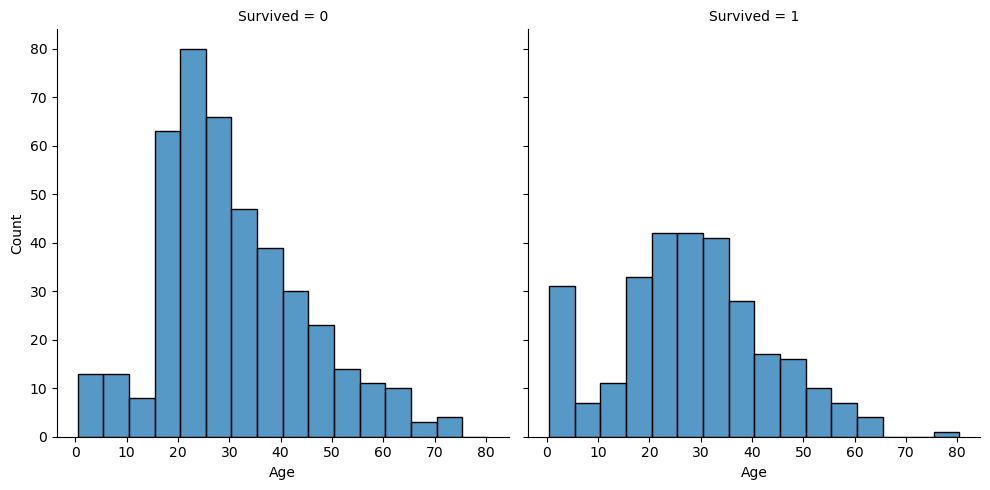

In [16]:
sns.displot(train_df, x='Age', col='Survived', binwidth=5, height=5)

The age data is continuous, we want to cut the data so cut the data with a qcut. Making 8 equal buckets of data in size. 

In [17]:
train_df['Age_Cut'] = pd.qcut(train_df['Age'], 8)
serving_df['Age_Cut'] = pd.qcut(serving_df['Age'], 8)

In [18]:
train_df.groupby(['Age_Cut'], as_index=False) ['Survived'].mean()

/var/folders/jm/v07b3fxn19l7wkl7xzlpb4mw0000gn/T/ipykernel_14145/3426193752.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df.groupby(['Age_Cut'], as_index=False) ['Survived'].mean()


,Age_Cut,Survived
0,"(0.419, 16.0]",0.550000
1,"(16.0, 20.125]",0.341772
2,"(20.125, 24.0]",0.367347
3,"(24.0, 28.0]",0.352941
4,"(28.0, 32.312]",0.416667
5,"(32.312, 38.0]",0.450549
6,"(38.0, 47.0]",0.329545
7,"(47.0, 80.0]",0.415730


In [19]:
train_df.loc[train_df['Age'] <= 16, 'Age'] = 0
train_df.loc[(train_df['Age'] > 16) & (train_df['Age'] <= 20.125), 'Age'] = 1
train_df.loc[(train_df['Age'] > 20.125) & (train_df['Age'] <= 24), 'Age'] = 2
train_df.loc[(train_df['Age'] > 24) & (train_df['Age'] <= 28), 'Age'] = 3
train_df.loc[(train_df['Age'] > 28) & (train_df['Age'] <= 32.312), 'Age'] = 4
train_df.loc[(train_df['Age'] > 32.312) & (train_df['Age'] <= 38), 'Age'] = 5
train_df.loc[(train_df['Age'] > 38) & (train_df['Age'] <= 47), 'Age'] = 6
train_df.loc[(train_df['Age'] > 47) & (train_df['Age'] <= 80), 'Age'] = 7
train_df.loc[train_df['Age'] > 80, 'Age']

serving_df.loc[serving_df['Age'] <= 16, 'Age'] = 0
serving_df.loc[(serving_df['Age'] > 16) & (serving_df['Age'] <= 20.125), 'Age'] = 1
serving_df.loc[(serving_df['Age'] > 20.125) & (serving_df['Age'] <= 24), 'Age'] = 2
serving_df.loc[(serving_df['Age'] > 24) & (serving_df['Age'] <= 28), 'Age'] = 3
serving_df.loc[(serving_df['Age'] > 28) & (serving_df['Age'] <= 32.312), 'Age'] = 4
serving_df.loc[(serving_df['Age'] > 32.312) & (serving_df['Age'] <= 38), 'Age'] = 5
serving_df.loc[(serving_df['Age'] > 38) & (serving_df['Age'] <= 47), 'Age'] = 6
serving_df.loc[(serving_df['Age'] > 47) & (serving_df['Age'] <= 80), 'Age'] = 7
serving_df.loc[serving_df['Age'] > 80, 'Age']

Series([], Name: Age, dtype: float64)

In [20]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Family_Size_Grouped,Age_Cut
0,1,0,3,"Braund, Mr. Owen Harris",male,2.0,1,0,A/5 21171,7.2500,NaN,S,2,Small,"(20.125, 24.0]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,5.0,1,0,PC 17599,71.2833,C85,C,2,Small,"(32.312, 38.0]"
2,3,1,3,"Heikkinen, Miss. Laina",female,3.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Alone,"(24.0, 28.0]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,5.0,1,0,113803,53.1000,C123,S,2,Small,"(32.312, 38.0]"
4,5,0,3,"Allen, Mr. William Henry",male,5.0,0,0,373450,8.0500,NaN,S,1,Alone,"(32.312, 38.0]"


Build a graph (seaborn) to display the information and see the distributions. Lets do this for Fare. The left graph displays those who did not survive, and on the right those who did survive.

Cut the fare, because the range is too big. Making it smaller with a qcut will make it easier to work with.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


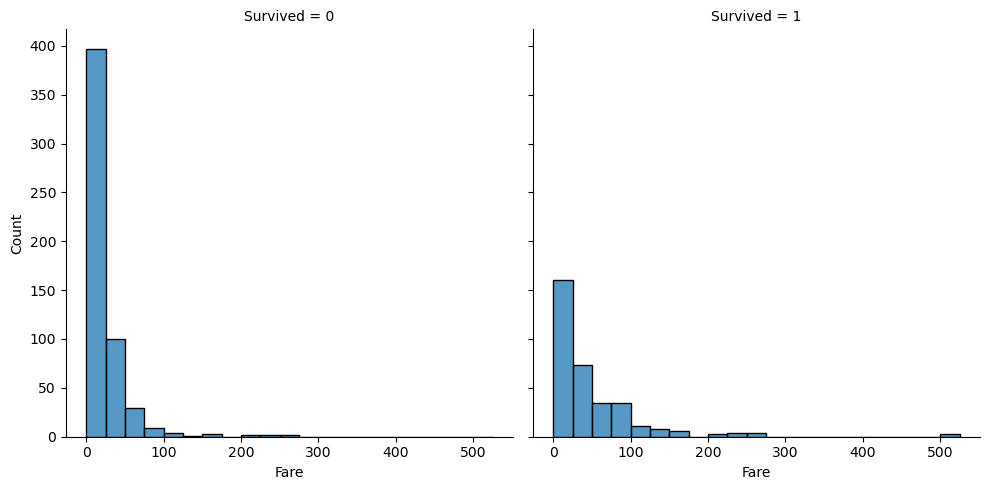

In [24]:
sns.displot(train_df, x='Fare', col='Survived', binwidth=25, height=5)

Cut the fare, because the range is too big. Making it smaller with a qcut will make it easier to work with.

In [25]:
train_df['Fare_Cut'] = pd.qcut(train_df['Fare'], 6)
serving_df['Fare_Cut'] = pd.qcut(serving_df['Fare'], 6)

In [26]:
train_df.groupby(['Fare_Cut'], as_index=False) ['Survived'].mean()

/var/folders/jm/v07b3fxn19l7wkl7xzlpb4mw0000gn/T/ipykernel_14145/2769472006.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df.groupby(['Fare_Cut'], as_index=False) ['Survived'].mean()


,Fare_Cut,Survived
0,"(-0.001, 7.775]",0.205128
1,"(7.775, 8.662]",0.190789
2,"(8.662, 14.454]",0.366906
3,"(14.454, 26.0]",0.436242
4,"(26.0, 52.369]",0.417808
5,"(52.369, 512.329]",0.697987


In [27]:
train_df.loc[train_df['Fare'] <= 7.775, 'Fare'] = 0
train_df.loc[(train_df['Fare'] > 7.775) & (train_df['Fare'] <= 8.662), 'Fare'] = 1
train_df.loc[(train_df['Fare'] > 8.662) & (train_df['Fare'] <= 14.454), 'Fare'] = 2
train_df.loc[(train_df['Fare'] > 14.454) & (train_df['Fare'] <= 26), 'Fare'] = 3
train_df.loc[(train_df['Fare'] > 26) & (train_df['Fare'] <= 52.369), 'Fare'] = 4
train_df.loc[(train_df['Fare'] > 52.369) & (train_df['Fare'] <= 512.329), 'Fare'] = 5
train_df.loc[train_df['Fare'] > 512.329, 'Fare']

serving_df.loc[train_df['Fare'] <= 7.775, 'Fare'] = 0
serving_df.loc[(train_df['Fare'] > 7.775) & (serving_df['Fare'] <= 8.662), 'Fare'] = 1
serving_df.loc[(train_df['Fare'] > 8.662) & (serving_df['Fare'] <= 14.454), 'Fare'] = 2
serving_df.loc[(train_df['Fare'] > 14.454) & (serving_df['Fare'] <= 26), 'Fare'] = 3
serving_df.loc[(train_df['Fare'] > 26) & (serving_df['Fare'] <= 52.369), 'Fare'] = 4
serving_df.loc[(train_df['Fare'] > 52.369) & (serving_df['Fare'] <= 512.329), 'Fare'] = 5
serving_df.loc[train_df['Fare'] > 512.329, 'Fare']

258    5.0
Name: Fare, dtype: float64

Lets see what information we can get from the name.

In [28]:
train_df['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

Perform a string split to seperate last and first names.

In [29]:
train_df['Name'].str.split(pat= ",", expand=True)

,0,1
0,Braund,Mr. Owen Harris
1,Cumings,Mrs. John Bradley (Florence Briggs Thayer)
2,Heikkinen,Miss. Laina
3,Futrelle,Mrs. Jacques Heath (Lily May Peel)
4,Allen,Mr. William Henry
...,...,...
886,Montvila,Rev. Juozas
887,Graham,Miss. Margaret Edith
888,Johnston,"Miss. Catherine Helen ""Carrie"""
889,Behr,Mr. Karl Howell


This extracts solely the first names.

In [30]:
train_df['Name'].str.split(pat= ",", expand=True)[1]

0                                  Mr. Owen Harris
1       Mrs. John Bradley (Florence Briggs Thayer)
2                                      Miss. Laina
3               Mrs. Jacques Heath (Lily May Peel)
4                                Mr. William Henry
                          ...                     
886                                    Rev. Juozas
887                           Miss. Margaret Edith
888                 Miss. Catherine Helen "Carrie"
889                                Mr. Karl Howell
890                                    Mr. Patrick
Name: 1, Length: 891, dtype: object

Perform a string split on the firstnames. 

In [31]:
train_df['Name'].str.split(pat= ",", expand=True)[1].str.split(pat= ".", expand=True)

,0,1,2
0,Mr,Owen Harris,None
1,Mrs,John Bradley (Florence Briggs Thayer),None
2,Miss,Laina,None
3,Mrs,Jacques Heath (Lily May Peel),None
4,Mr,William Henry,None
...,...,...,...
886,Rev,Juozas,None
887,Miss,Margaret Edith,None
888,Miss,"Catherine Helen ""Carrie""",None
889,Mr,Karl Howell,None


Extract the title of each person from the first names.

In [44]:
train_df['Name'].str.split(pat= ",", expand=True)[1].str.split(pat= ".", expand=True)[0]

0         Mr
1        Mrs
2       Miss
3        Mrs
4         Mr
       ...  
886      Rev
887     Miss
888     Miss
889       Mr
890       Mr
Name: 0, Length: 891, dtype: object

In [45]:
train_df['Title'] = train_df['Name'].str.split(pat= ",", expand=True)[1].str.split(pat= ".", expand=True)[0].apply(lambda x: x.strip())
serving_df['Title'] = serving_df['Name'].str.split(pat= ",", expand=True)[1].str.split(pat= ".", expand=True)[0].apply(lambda x: x.strip())

In [46]:
train_df.groupby(['Title'], as_index=False) ['Survived'].mean()

,Title,Survived
0,Capt,0.000000
1,Col,0.500000
2,Don,0.000000
3,Dr,0.428571
4,Jonkheer,0.000000
5,Lady,1.000000
6,Major,0.500000
7,Master,0.575000
8,Miss,0.697802
9,Mlle,1.000000


There are many different titles of people onboard the titanic, resulting in a total of 17 catagories. We can reduced this by grouping the types of titles.

Military: Capt, Col, Major
Noble: Jonkheer, the Countess, Don, Lady, Sir
Unmarried Female: Mlle, Ms, Mme

Master and Miss are titles for boys and girls under the age of 18. Therefore Miss will not be included in the Unmarried Female Catagory

In [47]:
train_df['Title'] = train_df['Title'].replace({
    'Capt' : 'Millitary',
    'Col' : 'Millitary',
    'Major' : 'Millitary',
    'Don' : 'Noble',
    'Jonkheer' : 'Noble',
    'the Countess' : 'Noble',
    'Lady' : 'Noble',
    'Sir' : 'Noble',
    'Mlle' : 'Unmarried Female',
    'Ms' : 'Unmarried Female',
    'Mme' : 'Unmarried Female',
})

serving_df['Title'] = serving_df['Title'].replace({
    'Capt' : 'Millitary',
    'Col' : 'Millitary',
    'Major' : 'Millitary',
    'Don' : 'Noble',
    'Jonkheer' : 'Noble',
    'the Countess' : 'Noble',
    'Lady' : 'Noble',
    'Sir' : 'Noble',
    'Mlle' : 'Unmarried Female',
    'Ms' : 'Unmarried Female',
    'Mme' : 'Unmarried Female',
})

In [50]:
train_df.groupby(['Title'], as_index=False) ['Survived'].agg(['count', 'mean'])

,Title,count,mean
0,Dr,7,0.428571
1,Master,40,0.575000
2,Millitary,5,0.400000
3,Miss,182,0.697802
4,Mr,517,0.156673
5,Mrs,125,0.792000
6,Noble,5,0.600000
7,Rev,6,0.000000
8,Unmarried Female,4,1.000000


As well as title, the lengt of ones names also reflected status. The longer your name the more likely you were someone of importance. So we are going to explore the survival rate dependent on name length using a simple lambda function.

In [51]:
train_df['Name_Length'] = train_df['Name'].apply(lambda x: len(x))
serving_df['Name_Length'] = serving_df['Name'].apply(lambda x: len(x))

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


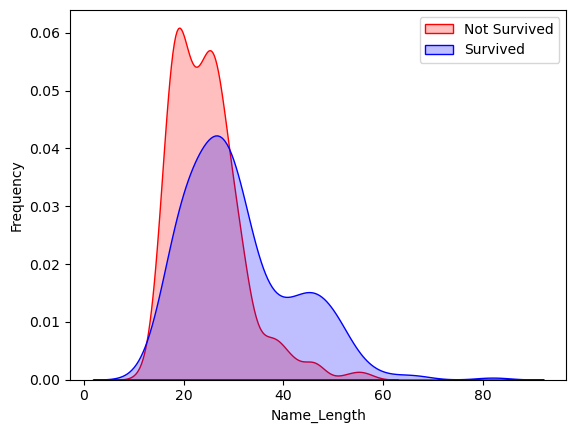

In [52]:
g = sns.kdeplot(train_df['Name_Length'][(train_df['Survived']==0) & (train_df['Name_Length'].notnull())], color='Red', fill=True)
g = sns.kdeplot(train_df['Name_Length'][(train_df['Survived']==1) & (train_df['Name_Length'].notnull())], ax=g, color='Blue', fill=True)
g.set_xlabel('Name_Length')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])


In [53]:
train_df['Name_LengthGB'] = pd.qcut(train_df['Name_Length'], 8)
serving_df['Name_LengthGB'] = pd.qcut(serving_df['Name_Length'], 8)

In [54]:
train_df.groupby(['Name_LengthGB'], as_index=False)['Survived'].mean()

/var/folders/jm/v07b3fxn19l7wkl7xzlpb4mw0000gn/T/ipykernel_14145/554738133.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df.groupby(['Name_LengthGB'], as_index=False)['Survived'].mean()


,Name_LengthGB,Survived
0,"(11.999, 18.0]",0.214286
1,"(18.0, 20.0]",0.252427
2,"(20.0, 23.0]",0.307692
3,"(23.0, 25.0]",0.346939
4,"(25.0, 27.25]",0.292929
5,"(27.25, 30.0]",0.428571
6,"(30.0, 38.0]",0.517241
7,"(38.0, 82.0]",0.745283


In [59]:
train_df.loc[train_df['Name_Length'] <= 18, 'Name_Size'] = 0
train_df.loc[(train_df['Name_Length'] > 18) & (train_df['Name_Length'] <= 20), 'Name_Size'] = 1
train_df.loc[(train_df['Name_Length'] > 20) & (train_df['Name_Length'] <= 23), 'Name_Size'] = 2
train_df.loc[(train_df['Name_Length'] > 23) & (train_df['Name_Length'] <= 25), 'Name_Size'] = 3
train_df.loc[(train_df['Name_Length'] > 25) & (train_df['Name_Length'] <= 27.25), 'Name_Size'] = 4
train_df.loc[(train_df['Name_Length'] > 27.25) & (train_df['Name_Length'] <= 30), 'Name_Size'] = 5
train_df.loc[(train_df['Name_Length'] > 30) & (train_df['Name_Length'] <= 38), 'Name_Size'] = 6
train_df.loc[(train_df['Name_Length'] > 38) & (train_df['Name_Length'] <= 82), 'Name_Size'] = 7
train_df.loc[train_df['Name_Length'] > 82, 'Name_Size']

serving_df.loc[serving_df['Name_Length'] <= 18, 'Name_Size'] = 0
serving_df.loc[(serving_df['Name_Length'] > 18) & (serving_df['Name_Length'] <= 20), 'Name_Size'] = 1
serving_df.loc[(serving_df['Name_Length'] > 20) & (serving_df['Name_Length'] <= 23), 'Name_Size'] = 2
serving_df.loc[(serving_df['Name_Length'] > 23) & (serving_df['Name_Length'] <= 25), 'Name_Size'] = 3
serving_df.loc[(serving_df['Name_Length'] > 25) & (serving_df['Name_Length'] <= 27.25), 'Name_Size'] = 4
serving_df.loc[(serving_df['Name_Length'] > 27.25) & (serving_df['Name_Length'] <= 30), 'Name_Size'] = 5
serving_df.loc[(serving_df['Name_Length'] > 30) & (serving_df['Name_Length'] <= 38), 'Name_Size'] = 6
serving_df.loc[(serving_df['Name_Length'] > 38) & (serving_df['Name_Length'] <= 82), 'Name_Size'] = 7
serving_df.loc[serving_df['Name_Length'] > 82, 'Name_Size']



Series([], Name: Name_Size, dtype: float64)

In [60]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Family_Size_Grouped,Age_Cut,Fare_Cut,Title,Name_Length,Name_LengthGB,Name_Size
0,1,0,3,"Braund, Mr. Owen Harris",male,2.0,1,0,A/5 21171,0.0,NaN,S,2,Small,"(20.125, 24.0]","(-0.001, 7.775]",Mr,23,"(20.0, 23.0]",2.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,5.0,1,0,PC 17599,5.0,C85,C,2,Small,"(32.312, 38.0]","(52.369, 512.329]",Mrs,51,"(38.0, 82.0]",7.0
2,3,1,3,"Heikkinen, Miss. Laina",female,3.0,0,0,STON/O2. 3101282,1.0,NaN,S,1,Alone,"(24.0, 28.0]","(7.775, 8.662]",Miss,22,"(20.0, 23.0]",2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,5.0,1,0,113803,5.0,C123,S,2,Small,"(32.312, 38.0]","(52.369, 512.329]",Mrs,44,"(38.0, 82.0]",7.0
4,5,0,3,"Allen, Mr. William Henry",male,5.0,0,0,373450,1.0,NaN,S,1,Alone,"(32.312, 38.0]","(7.775, 8.662]",Mr,24,"(23.0, 25.0]",3.0


 ## Preparing the Dataset

Apply the following transformations on the dataset.

Tokenize the names. For example, "Braund, Mr. Owen Harris" will become ["Braund", "Mr.", "Owen", "Harris"].
Extract any prefix in the ticket. For example ticket "STON/O2. 3101282" will become "STON/O2." and 3101282.

In [21]:
'''
This code defines a function named `preprocess` that takes a DataFrame `df` as input. Inside the function:
1. It creates a deep copy of the input DataFrame `df` to ensure that any changes made to the original DataFrame are not reflected in the copy.
2. It defines three helper functions:
   - `normalise_name`: This function removes certain characters (such as commas, parentheses, periods, double quotes, and single quotes) from each word in a name and joins them back together with spaces.
   - `ticket_number`: This function extracts the last element (presumably a ticket number) from a string by splitting it on spaces.
   - `ticket_items`: This function splits a string into items based on spaces and returns "NONE" if there is only one item, otherwise it joins all items except the last one with underscores.
3. It applies the `normalise_name`, `ticket_number`, and `ticket_items` functions to specific columns in the DataFrame `df` ("Name" and "Ticket") and creates new columns "Ticket_number" and "Ticket_item" with the processed data.
4. Finally, it returns the modified DataFrame `df`.
'''
def preprocess(df):

    df = df.copy()

    def normalise_name(x):
        return " ".join([v.strip(",()[].\"'") for v in x.split(" ")])
    
    def ticket_number(x):
        return x.split(" ")[-1]
    
    def ticket_items(x):
        items = x.split(" ")
        if len(items) == 1:
            return "NONE"
        return "_".join(items[0:-1])
    
    df["Name"] = df["Name"].apply(normalise_name)
    df["Ticket_number"] = df["Ticket"].apply(ticket_number)
    df["Ticket_item"] = df["Ticket"].apply(ticket_items)

    return df

preprocessed_train_df = preprocess(train_df)
preprocessed_serving_df = preprocess(serving_df)

preprocessed_train_df.head(5)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Family_Size_Grouped,Age_Cut,Ticket_number,Ticket_item
0,1,0,3,Braund Mr Owen Harris,male,2.0,1,0,A/5 21171,7.2500,NaN,S,2,Small,"(20.125, 24.0]",21171,A/5
1,2,1,1,Cumings Mrs John Bradley Florence Briggs Thayer,female,5.0,1,0,PC 17599,71.2833,C85,C,2,Small,"(32.312, 38.0]",17599,PC
2,3,1,3,Heikkinen Miss Laina,female,3.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Alone,"(24.0, 28.0]",3101282,STON/O2.
3,4,1,1,Futrelle Mrs Jacques Heath Lily May Peel,female,5.0,1,0,113803,53.1000,C123,S,2,Small,"(32.312, 38.0]",113803,NONE
4,5,0,3,Allen Mr William Henry,male,5.0,0,0,373450,8.0500,NaN,S,1,Alone,"(32.312, 38.0]",373450,NONE


Let's keep the list of the input features of the model. Notably, we don't want to train our model on the "PassengerId" and "Ticket" features.

In [22]:
input_features = list(preprocessed_train_df.columns)
input_features.remove("Ticket")
input_features.remove("PassengerId")
input_features.remove("Survived")
#input_features.remove("Ticket_number")

print(f"Input features: {input_features}")

Input features: ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Family_Size', 'Family_Size_Grouped', 'Age_Cut', 'Ticket_number', 'Ticket_item']
